In [1]:
from inda_mir.modeling.models import *
from inda_mir.modeling.evaluation import *
from inda_mir.loaders import load_data_partition

import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
data_partition_path = "../output/train_test_split/random_split_v3.data"
data = load_data_partition(data_partition_path)
X_train, y_train = data.get_numpy_train_data()
X_test, y_test = data.get_numpy_test_data()

Counter(y_train)

Counter({'guitar': 2985,
         'drums': 2373,
         'bass': 2152,
         'keyboards': 1888,
         'vocals': 1701,
         'brass': 209})

In [3]:
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
Counter(y_train)

Counter({'guitar': 2985,
         'vocals': 2985,
         'drums': 2985,
         'keyboards': 2985,
         'bass': 2985,
         'brass': 2985})

In [4]:
best_params = {'learning_rate': 0.1, 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1.2}
lgbm = LightGBMClassifier(**best_params)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 17910, number of used features: 253
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

# Sample level, 50% Threshold

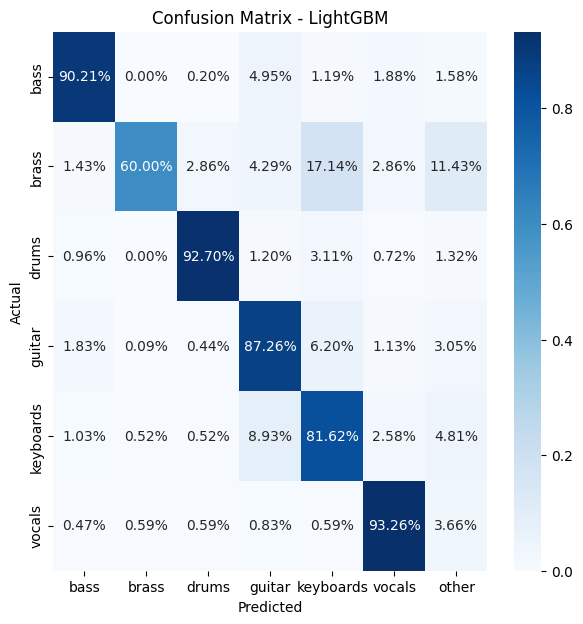

In [23]:
plot_confusion_matrix(y_test, X_test, lgbm)

# Sample level, 90% Threshold

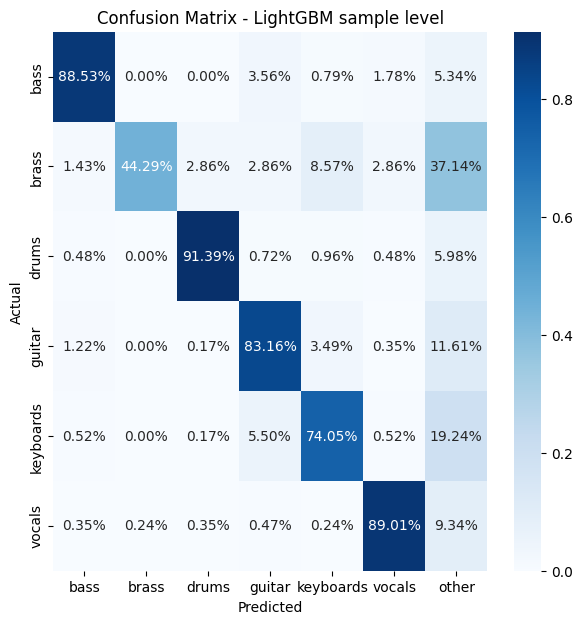

In [5]:
labels = lgbm.classes_
cm = confusion_matrix(y_true=y_test, y_pred=lgbm.predict(X_test, threshold=0.7), labels=labels)[: len(labels) - 1]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(len(labels), len(labels)))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels[:-1],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {lgbm.name} sample level')
plt.show()

In [24]:
data.labels

array(['bass', 'brass', 'drums', 'guitar', 'keyboards', 'vocals'],
      dtype='<U9')

In [38]:
print_classification_report(y_test, lgbm.predict(X_test, threshold=0.9), data.labels)

              precision    recall  f1-score   support

        bass       0.99      0.85      0.91      1011
       brass       0.94      0.21      0.35        70
       drums       1.00      0.87      0.93       836
      guitar       0.97      0.74      0.84      1146
   keyboards       0.96      0.60      0.74       582
      vocals       0.97      0.80      0.88       846

   micro avg       0.98      0.78      0.87      4491
   macro avg       0.97      0.68      0.78      4491
weighted avg       0.98      0.78      0.86      4491



# Track level analysis

In [6]:
aux_dataset = data.X_test[['track_id']].copy()
aux_dataset['truth'] = data.y_test
aux_dataset['prediction'] = lgbm.predict(X_test, threshold=0.7)

In [7]:
class_by_tracks = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'prediction': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

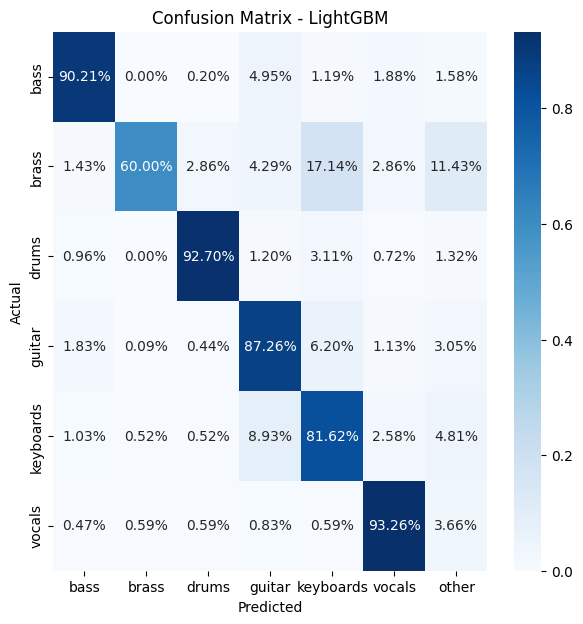

In [41]:
plot_confusion_matrix(y_test, X_test, lgbm)

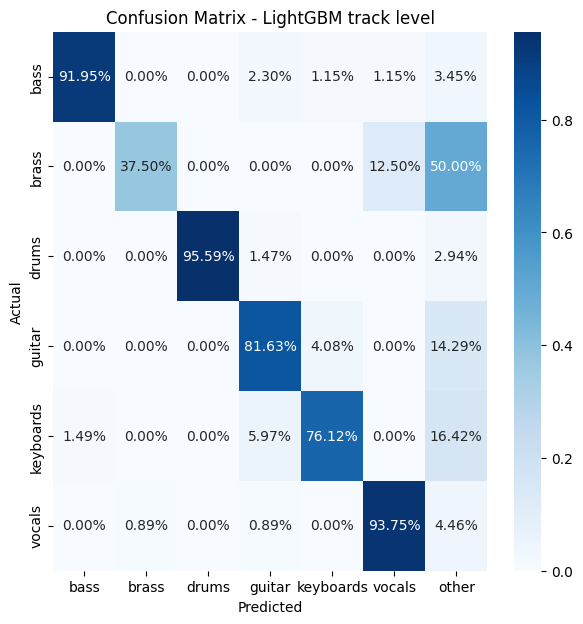

In [8]:
labels = lgbm.classes_
cm = confusion_matrix(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)[: len(labels) - 1]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(len(labels), len(labels)))
sns.heatmap(
    cm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels[:-1],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {lgbm.name} track level')
plt.show()

In [43]:
print_classification_report(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)

              precision    recall  f1-score   support

        bass       0.99      0.89      0.93        87
       brass       1.00      0.12      0.22         8
       drums       1.00      0.93      0.96        68
      guitar       0.99      0.74      0.85        98
   keyboards       0.97      0.54      0.69        67
      vocals       0.99      0.84      0.91       112
       other       0.00      0.00      0.00         0

    accuracy                           0.78       440
   macro avg       0.85      0.58      0.65       440
weighted avg       0.99      0.78      0.86       440



/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathanfernandes/Documents/track_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_